# Building a Residual Network

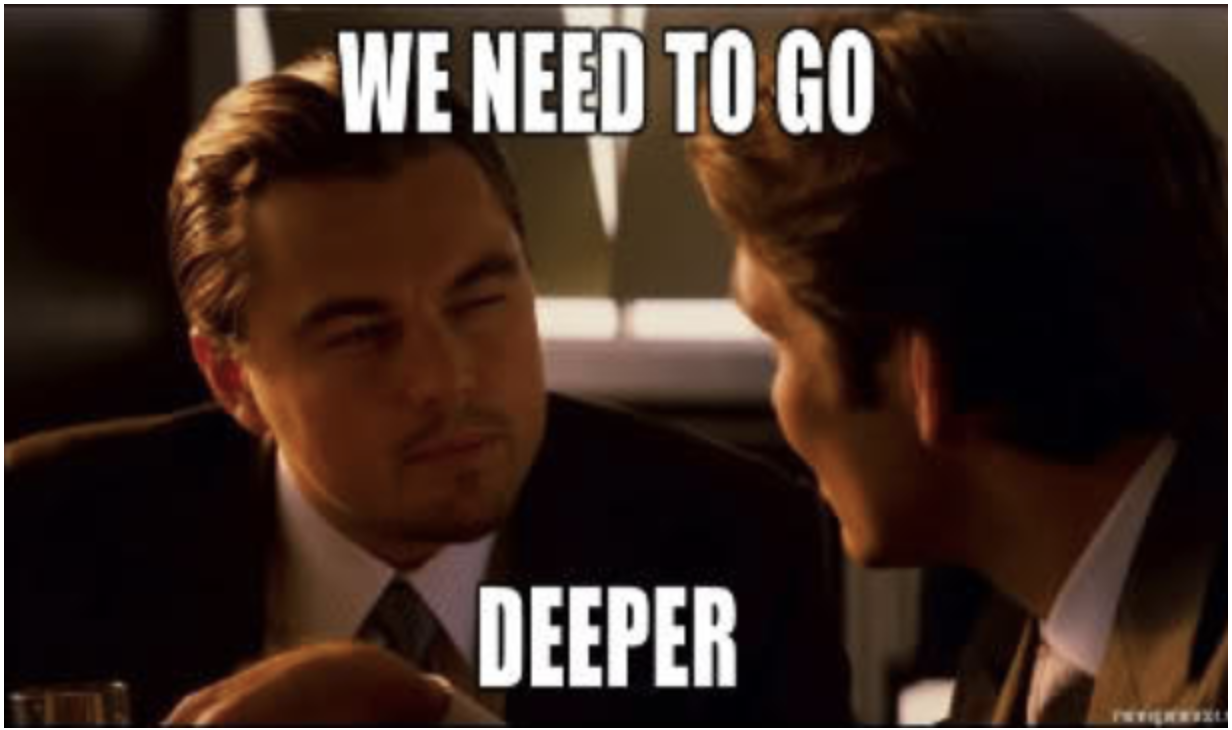

#### The Problem of Very Deep Neural Networks
A deep neural network can represent very complex functions. However, vanishing gradients is a huge barrier; gradients exponentially decrease, slowing down learning by a lot.

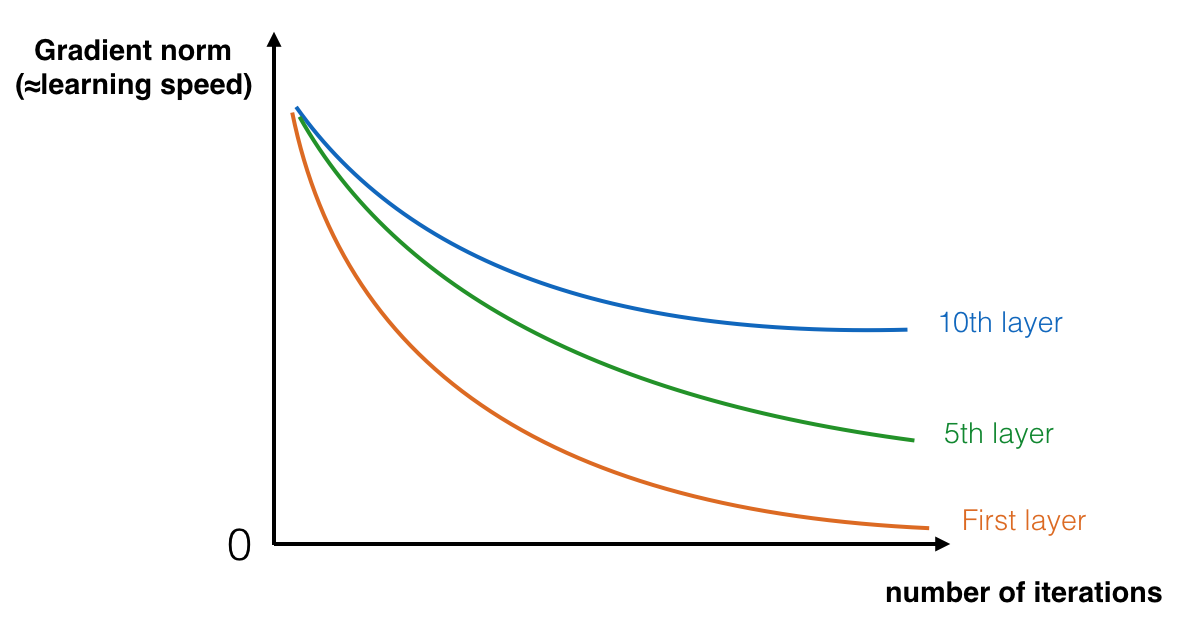

#### Building a Residual Network

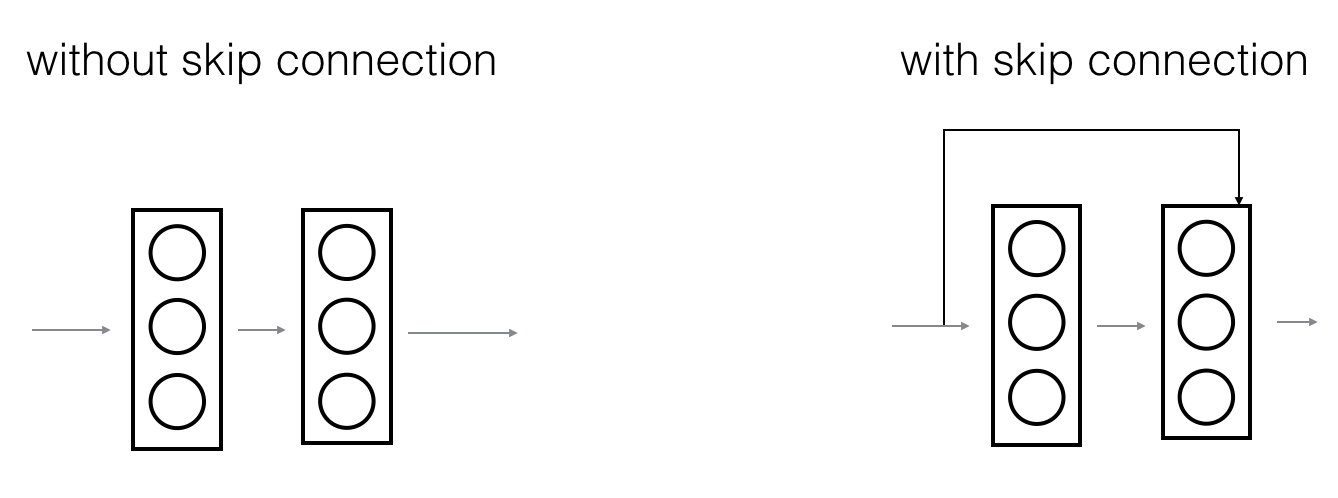

ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.

On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

#### Packages

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from test_utils import summary, comparator
import public_tests

%matplotlib inline

### Identity Block

In the case where the input activation has the same dimension as the output activation.

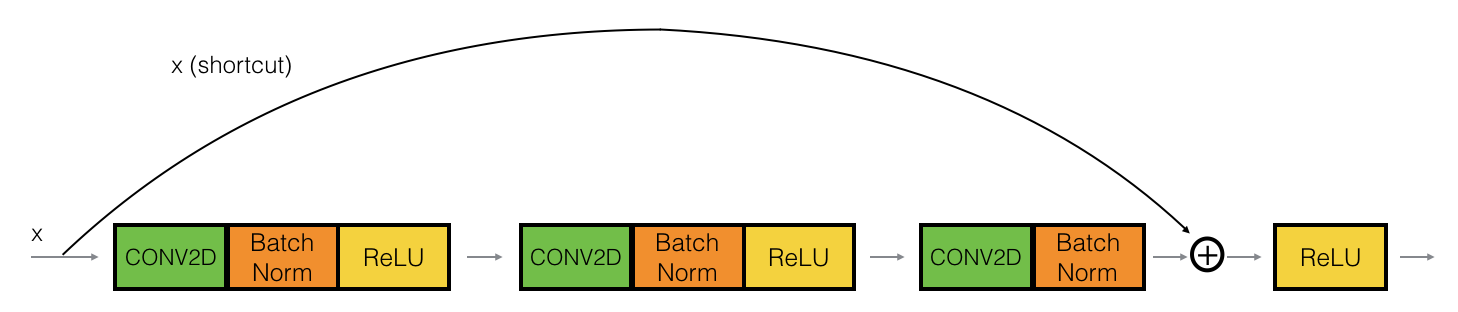

In [2]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path 
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ## Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)

    return X

In [3]:
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=True)
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))

With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.7123  192.7123  192.7123   96.85615]
  [ 96.85615  96.85615  96.85615  48.92808]]

 [[578.1369  578.1369  578.1369  290.56845]
  [290.56845 290.56845 290.56845 146.78423]]]
96.85615

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.99991 4.99991 4.99991 3.25948]
  [3.25948 3.25948 3.25948 2.40739]]]


### Convolutional Block

When input and output dimensions don't match up

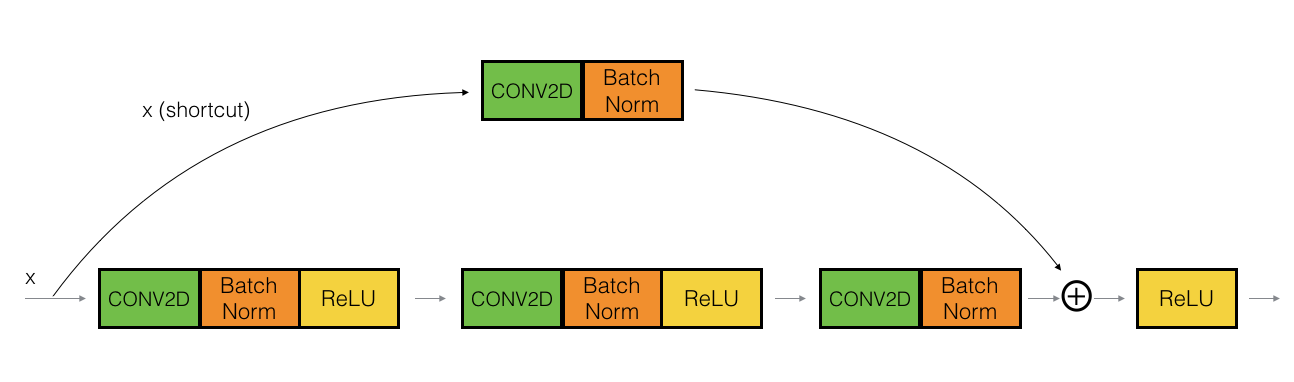

In [4]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path 
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [5]:
from outputs import convolutional_block_output1, convolutional_block_output2
np.random.seed(1)
#X = np.random.randn(3, 4, 4, 6).astype(np.float32)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = convolutional_block(X, f = 2, filters = [2, 4, 6], training=False)

print(A[0])

tf.Tensor(
[[[0.         0.66683805 0.         0.         0.888539   0.5274254 ]
  [0.         0.65053654 0.         0.         0.8959285  0.49965227]]

 [[0.         0.63120776 0.         0.         0.86362475 0.47643146]
  [0.         0.568832   0.         0.         0.8553412  0.417093  ]]], shape=(2, 2, 6), dtype=float32)


### ResNet Model (50 Layers)

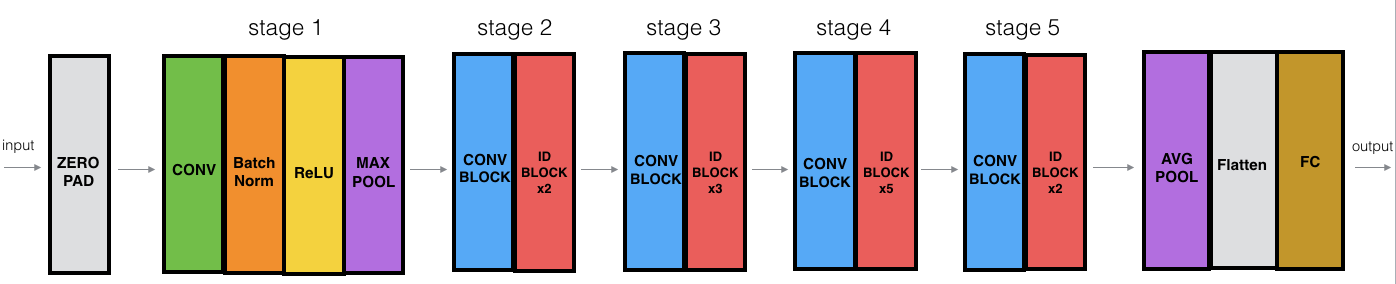

In [6]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    ## Stage 3 
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    
    ## Stage 4 (
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [7]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 32, 32, 64)   256         conv2d_10[0][0]                  
______________________________________________________________________________________________

#### Compile

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Dataset

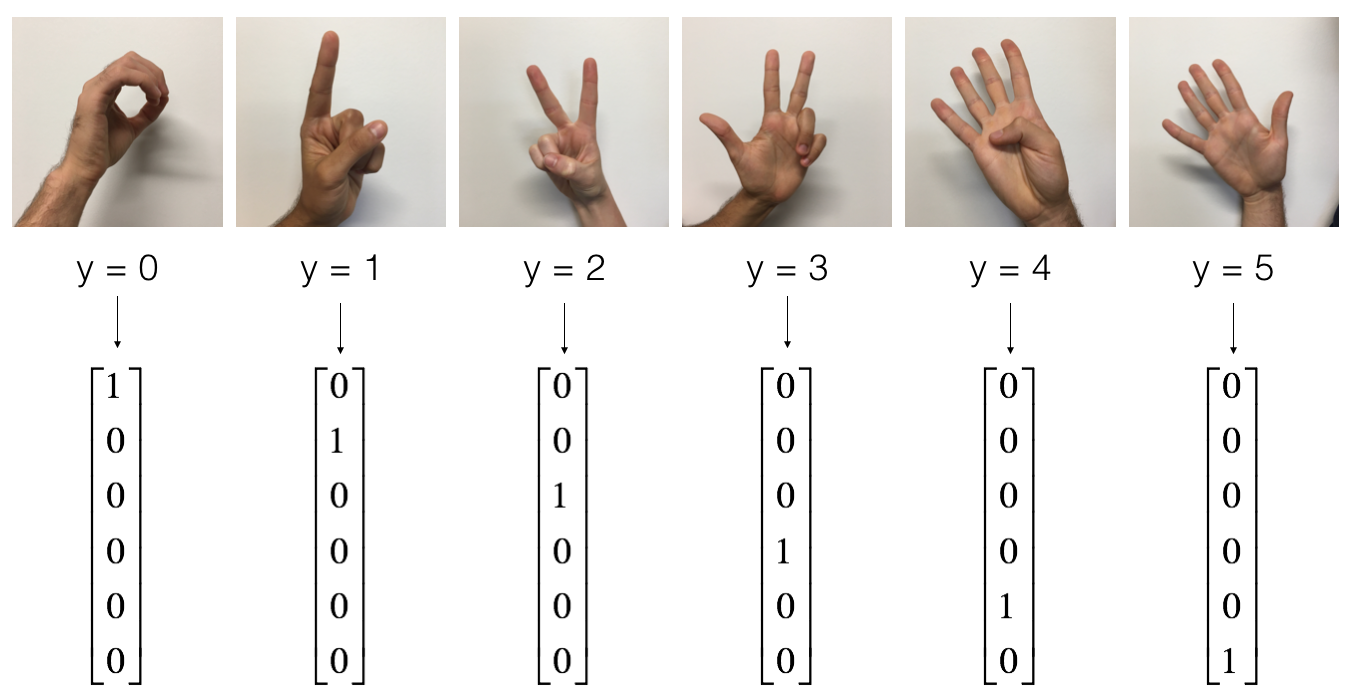

In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#### Training

In [10]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 69s 2s/step - loss: 2.6574 - accuracy: 0.3972
Epoch 2/10
34/34 [==============================] - 74s 2s/step - loss: 1.0324 - accuracy: 0.7352
Epoch 3/10
34/34 [==============================] - 72s 2s/step - loss: 1.0387 - accuracy: 0.6759
Epoch 4/10
34/34 [==============================] - 73s 2s/step - loss: 0.6344 - accuracy: 0.8491
Epoch 5/10
34/34 [==============================] - 71s 2s/step - loss: 0.3402 - accuracy: 0.9037
Epoch 6/10
34/34 [==============================] - 67s 2s/step - loss: 0.2196 - accuracy: 0.9389
Epoch 7/10
34/34 [==============================] - 67s 2s/step - loss: 0.2106 - accuracy: 0.9426
Epoch 8/10
34/34 [==============================] - 66s 2s/step - loss: 0.1953 - accuracy: 0.9370
Epoch 9/10
34/34 [==============================] - 64s 2s/step - loss: 0.2385 - accuracy: 0.9380
Epoch 10/10
34/34 [==============================] - 65s 2s/step - loss: 0.2474 - accuracy: 0.9241


#### Evaluation

In [11]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 241ms/step - loss: 0.3623 - accuracy: 0.8833
Loss = 0.3622598946094513
Test Accuracy = 0.8833333253860474


In [12]:
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

Input image shape: (1, 64, 64, 3)
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[3.36188660e-03 3.76563833e-07 4.13470790e-02 1.24374576e-01
  6.92027986e-01 1.38888076e-01]]
Class: 4


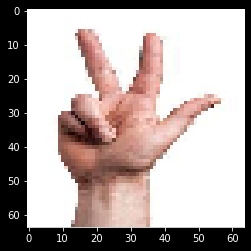

In [13]:
img_path = '3fing.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))

### Using a Pre-Trained Model

In [14]:
pre_trained_model = tf.keras.models.load_model('resnet50.h5')

In [15]:
preds = pre_trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 197ms/step - loss: 0.1596 - accuracy: 0.9500
Loss = 0.15958665311336517
Test Accuracy = 0.949999988079071


Input image shape: (1, 64, 64, 3)
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[3.1385839e-03 6.8280101e-06 1.8298933e-03 1.4809822e-02 9.4628507e-01
  3.3929743e-02]]
Class: 4


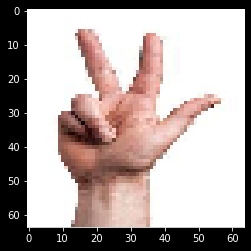

In [16]:
img_path = '3fing.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = pre_trained_model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))